In [1]:
import numpy as np
from numpy.random import default_rng
from scipy import signal
from lfp_prediction.config import params

RNG = default_rng(seed=67)

RAW_LFP = '/home/matt/repos/Research/Neuron_Burst_Analysis/data/raw_data/LFP_elec_combine.txt'

In [2]:
def get_whitenoise(time_s=300000, channels=1):
    osc_band = np.array([0.08, 0.14])
    b, a = signal.butter(4, osc_band, btype='bandpass', output='ba')

    with open(RAW_LFP) as f:
        lfp_in = f.read().splitlines()
    lfp_in = np.array([float(x) for x in lfp_in]).reshape((-1, 1))

    noise = RNG.normal(0, np.std(lfp_in), (time_s, channels))

    noise_filt = signal.lfilter(b, a, noise, axis=0)

    f_data = []
    f_labels = []
    for i in range(noise.shape[0] - (params.PREVIOUS_TIME + params.LOOK_AHEAD)):
        h = i + params.PREVIOUS_TIME
        f_data.append(noise[i:h, :].reshape((-1, params.PREVIOUS_TIME * params.INPUT_FEATURES)))
        f_labels.append(noise_filt[h:h + params.LOOK_AHEAD, 0].reshape((-1, params.LOOK_AHEAD)))
    f_data = np.stack(f_data, axis=0)
    f_labels = np.stack(f_labels, axis=0)
    return f_data, f_labels

data, labels = get_whitenoise()
print(data.shape)
print(labels.shape)

(298876, 1, 1024)
(298876, 1, 100)


In [3]:
def get_whitenoise_broken(time_s=300000, channels=1):
    osc_band = np.array([0.08, 0.14])
    b, a = signal.butter(4, osc_band, btype='bandpass', output='ba')

    with open(RAW_LFP) as f:
        lfp_in = f.read().splitlines()
    lfp_in = np.array([float(x) for x in lfp_in]).reshape((-1, 1))

    noise = RNG.normal(0, np.std(lfp_in), (time_s, channels))

    f_data = []
    f_labels = []
    for i in range(noise.shape[0] - (params.PREVIOUS_TIME + params.LOOK_AHEAD)):
        h = i + params.PREVIOUS_TIME
        f_data.append(noise[i:h, :].reshape((-1, params.PREVIOUS_TIME * params.INPUT_FEATURES)))
        f_labels.append(signal.lfilter(b, a, noise[h:h+params.LOOK_AHEAD,0], axis=0).reshape((-1, params.LOOK_AHEAD)))
    f_data = np.stack(f_data, axis=0)
    f_labels = np.stack(f_labels, axis=0)
    return f_data, f_labels

data, labels = get_whitenoise_broken()
print(data.shape)
print(labels.shape)

(298876, 1, 1024)
(298876, 1, 100)


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_data = DataLoader(TensorDataset(torch.Tensor(data[:200000, :, :]), torch.Tensor(labels[:200000, :, :])), batch_size=batch_size, shuffle=True)
valid_data = DataLoader(TensorDataset(torch.Tensor(data[200000:, :, :]), torch.Tensor(labels[200000:, :, :])), batch_size=batch_size, shuffle=False)

In [5]:
import torch.nn as nn
from tqdm.notebook import tqdm

def train_model(model,training_loader,validation_loader,epochs,device):
    #splitting the dataloaders to generalize code
    data_loaders = {"train": training_loader, "val": validation_loader}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    loss_func = nn.MSELoss()
    decay_rate = .99995 #0.98 #decay the lr each step to 98% of previous lr
    lr_sch = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

    """
    You can easily adjust the number of epochs trained here by changing the number in the range
    """
    for epoch in tqdm(range(epochs), position=0, leave=True):
        train_loss = 0.0
        val_loss = 0.0
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            for i, (x, y) in enumerate(data_loaders[phase]):
                if params.RECURRENT_NET:
                    x = torch.transpose(x, 2, 1)
                x = x.to(device)
                output = model(x)
                y = y.to(device)
                loss = loss_func(torch.squeeze(output), torch.squeeze(y))
                #backprop
                optimizer.zero_grad()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()

            if phase == 'train':
                train_loss = running_loss
                lr_sch.step()
            else:
                val_loss = running_loss

        # shows total loss
        if epoch%5 == 0:
            tqdm.write('[%d, %5d] train loss: %.6f val loss: %.6f' % (epoch + 1, i + 1, train_loss, val_loss))

In [6]:
import copy
from lfp_prediction.models.LFPNet import FCN

model = FCN(in_size=1024, h_size=500, out_size=100)
model_initial = copy.deepcopy(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
train_model(model, train_data, valid_data, 50, device)

  0%|          | 0/50 [00:00<?, ?it/s]

[1,  3090] train loss: 0.569515 val loss: 0.269774
[6,  3090] train loss: 0.558147 val loss: 0.270909
[11,  3090] train loss: 0.558548 val loss: 0.269439
[16,  3090] train loss: 0.558969 val loss: 0.273190
[21,  3090] train loss: 0.559243 val loss: 0.270061
[26,  3090] train loss: 0.559350 val loss: 0.269934
[31,  3090] train loss: 0.559536 val loss: 0.271054
[36,  3090] train loss: 0.559668 val loss: 0.272869
[41,  3090] train loss: 0.559551 val loss: 0.270921
[46,  3090] train loss: 0.559718 val loss: 0.270747


In [7]:
model.eval()
x = torch.Tensor(data[200000,:,:]).to(device)
output = model(x)
out = output.detach().cpu().numpy()

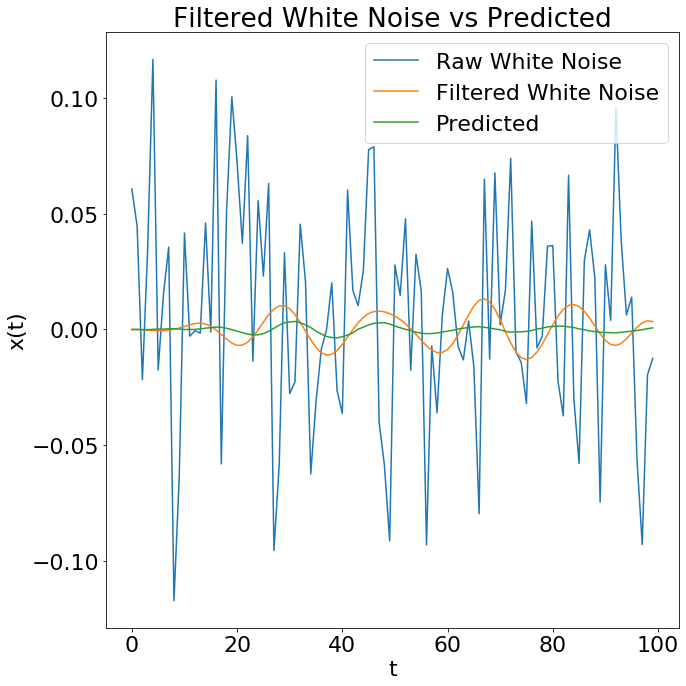

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 22

fig, axs = plt.subplots()

t = np.arange(0, 100, 1)

time_var = 100

axs.plot(t, data[200001,0,:100], label='Raw White Noise')
axs.plot(t, labels[200000,0,:], label='Filtered White Noise')
axs.plot(t, out[0,:], label='Predicted')

axs.set_xlabel('t')
axs.set_ylabel('x(t)')
axs.set_title('Filtered White Noise vs Predicted')
axs.legend(loc='best')

fig.tight_layout()
plt.show()